<a href="https://colab.research.google.com/github/Sajish06/task7/blob/main/task7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q scikit-learn pandas matplotlib seaborn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import pickle

print("Packages ready. Current working dir:", os.getcwd())

Packages ready. Current working dir: /content


In [2]:
from google.colab import files
uploaded = files.upload()

csv_path = list(uploaded.keys())[0]
print("Loaded:", csv_path)

df = pd.read_csv(csv_path)
df.head()

Saving breast-cancer.csv to breast-cancer.csv
Loaded: breast-cancer.csv


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
print("Shape:", df.shape)
print(df.info())
print(df.describe().T)

print("\nMissing values per column:\n", df.isnull().sum())

for c in df.columns:
    if c.lower().startswith('id') or c.lower().startswith('unnamed'):
        df.drop(columns=c, inplace=True)

possible_targets = ['target', 'label', 'diagnosis', 'Outcome', 'Class']
target_col = None
for t in possible_targets:
    if t in df.columns:
        target_col = t
        break

if target_col is None:
    target_col = df.columns[-1]
print("Using target column:", target_col)
print(df[target_col].value_counts())

Shape: (569, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter

In [4]:
if df[target_col].dtype == 'object' or df[target_col].dtype.name == 'category':
    le = LabelEncoder()
    df[target_col] = le.fit_transform(df[target_col])
    print("Label classes:", le.classes_)

Label classes: ['B' 'M']


In [5]:
X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()

non_numeric = X.select_dtypes(include=['object', 'category']).columns.tolist()
if non_numeric:
    print("Non-numeric columns (dropping for simplicity):", non_numeric)
    X = X.drop(columns=non_numeric)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (455, 30) Test shape: (114, 30)


In [6]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y)

print("Explained variance ratio (2 PCs):", pca.explained_variance_ratio_)

Explained variance ratio (2 PCs): [0.44272026 0.18971182]


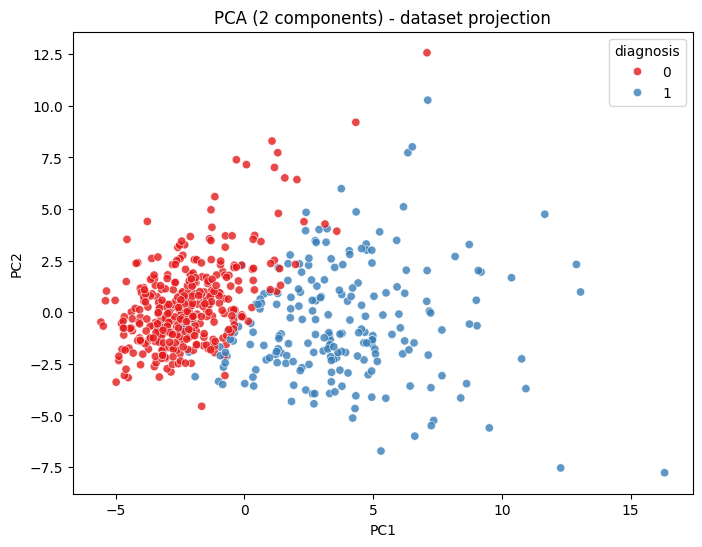

In [7]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='Set1', alpha=0.8)
plt.title("PCA (2 components) - dataset projection")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

In [8]:
svm_linear = SVC(kernel='linear', probability=True, random_state=42)
svm_linear.fit(X_train, y_train)
y_pred_lin = svm_linear.predict(X_test)
print("Linear SVM accuracy:", accuracy_score(y_test, y_pred_lin))
print(classification_report(y_test, y_pred_lin))

svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)
print("RBF SVM accuracy:", accuracy_score(y_test, y_pred_rbf))
print(classification_report(y_test, y_pred_rbf))

Linear SVM accuracy: 0.9649122807017544
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114

RBF SVM accuracy: 0.9736842105263158
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



In [9]:
param_grid_rbf = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1, 1]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rbf = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=42),
                        param_grid_rbf, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)
grid_rbf.fit(X_train, y_train)
print("Best RBF params:", grid_rbf.best_params_)
print("Best CV score (RBF):", grid_rbf.best_score_)

best_rbf = grid_rbf.best_estimator_
y_pred = best_rbf.predict(X_test)
print("Test accuracy (best RBF):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RBF params: {'C': 10, 'gamma': 0.01}
Best CV score (RBF): 0.9780219780219781
Test accuracy (best RBF): 0.9824561403508771
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [10]:
param_grid_lin = {'C': [0.01, 0.1, 1, 10, 100]}
grid_lin = GridSearchCV(SVC(kernel='linear', probability=True, random_state=42),
                        param_grid_lin, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)
grid_lin.fit(X_train, y_train)
print("Best Linear params:", grid_lin.best_params_)
print("Best CV score (Linear):", grid_lin.best_score_)

best_lin = grid_lin.best_estimator_
y_pred = best_lin.predict(X_test)
print("Test accuracy (best Linear):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Linear params: {'C': 0.1}
Best CV score (Linear): 0.9670329670329669
Test accuracy (best Linear): 0.9824561403508771
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [11]:
final_model = best_rbf

scores = cross_val_score(final_model, X_scaled, y, cv=cv, scoring='accuracy', n_jobs=-1)
print("Cross-val accuracy scores:", scores)
print("Mean CV accuracy:", scores.mean(), "Std:", scores.std())

Cross-val accuracy scores: [1.         0.94736842 0.98245614 0.99122807 0.98230088]
Mean CV accuracy: 0.9806707033069397 Std: 0.01788835926984936


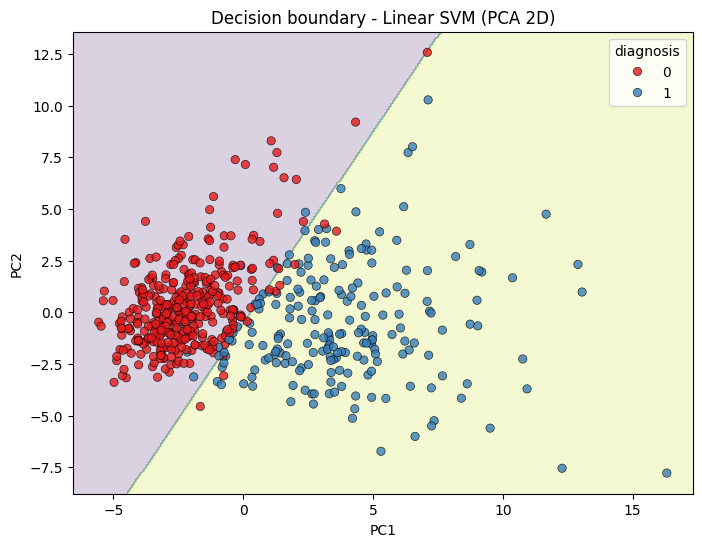

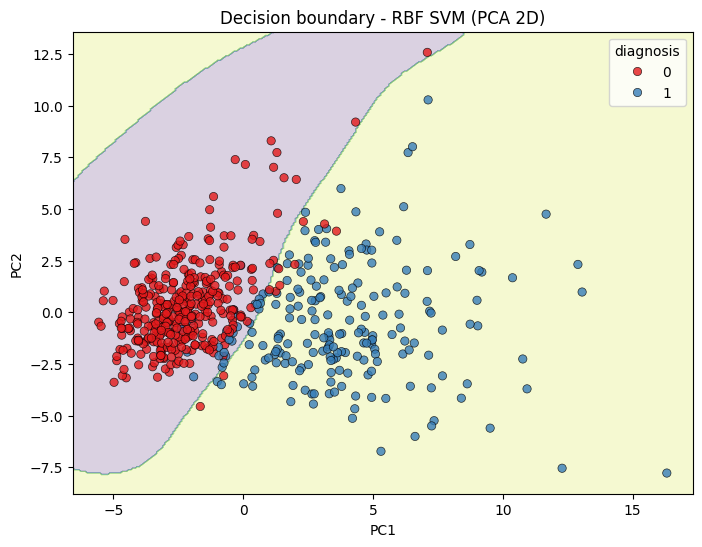

In [12]:
svc2_lin = SVC(kernel='linear', C=1.0, probability=False, random_state=42).fit(X_pca_train, y_pca_train)
svc2_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=False, random_state=42).fit(X_pca_train, y_pca_train)

def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.2)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, palette='Set1', alpha=0.8, edgecolor='k')
    plt.title(title)
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()

plot_decision_boundary(svc2_lin, X_pca, y, "Decision boundary - Linear SVM (PCA 2D)")
plot_decision_boundary(svc2_rbf, X_pca, y, "Decision boundary - RBF SVM (PCA 2D)")

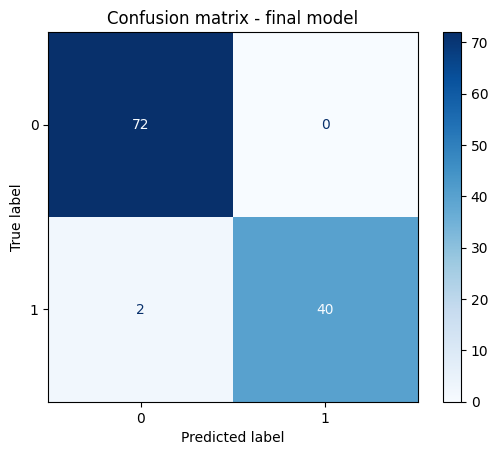

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

y_test_pred = final_model.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(y))
disp.plot(cmap='Blues')
plt.title("Confusion matrix - final model")
plt.show()